In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pylab as plt
%pylab inline
import numpy as np
import geopandas as gpd
import requests, zipfile, StringIO
import re

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [270]:
# Read in additional files
url_zip = 'https://www.dropbox.com/sh/nlbj8whi5izbihr/AAD8CvKIYMnVpKUcBDazRe22a?dl=1'
r = requests.get(url_zip)
zip_ = zipfile.ZipFile(StringIO.StringIO(r.content))
filename_zip = 'ZIP_spatial/ZIP_CODE_040114.shp'
filename_tax = 'Tax_rates.csv'
filename_assessment = 'dof_assessments_merged.csv'
filename_files = 'Files.csv'

In [271]:
# urls to the data
files = pd.read_csv(zip_.open(filename_files))
files.head(2)

In [287]:
# Create three lists
list_sales_detail = list(files['Filenames_Links'][:5])
older_list = list(files['Filenames_Links'][5:20])
even_older_list = list(files['Filenames_Links'][20:])

In [11]:
# Read in zip code shapes for plotting
zipcodes = gpd.GeoDataFrame.from_file(filename_zip)#zip_.open(filename)) # Does not work...
zipcodes = zipcodes[['ZIPCODE','geometry']]
zipcodes.ZIPCODE = zipcodes.ZIPCODE.astype(int)
zipcodes.rename(columns={'ZIPCODE':'ZIP_CODE'},inplace=True)

In [120]:
# Add tax rate information
tax = pd.read_csv(zip_.open(filename_tax))
tax = tax.convert_objects(convert_numeric=True)
filename_assessment = 'dof_assessments_merged.csv'

In [18]:
# Reading newer data
# Create empty dataframe to store values
sales_detail_recent = pd.DataFrame()
for url in list_sales_detail:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_recent = sales_detail_recent.append(xl_data)

In [19]:
# Reading older data
sales_detail_old = pd.DataFrame()
for url in older_list:
    xl_data = pd.read_excel(url, header=4)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_old = sales_detail_old.append(xl_data)

In [20]:
# Reading even older data
sales_detail_older = pd.DataFrame()
for url in even_older_list:
    xl_data = pd.read_excel(url, header=3)
    xl_data.columns = xl_data.columns.map(lambda x: x.rstrip('\n').replace(' ','_'))
    sales_detail_older = sales_detail_older.append(xl_data)

In [25]:
# Create a subset
def subset(df):
    df = df[(df.TAX_CLASS_AT_TIME_OF_SALE<3)&(df.SALE_PRICE>100000)&
                                     (df.BUILDING_CLASS_CATEGORY != '05  TAX CLASS 1 VACANT LAND')]
    return df

In [26]:
# Prepare datasets before joining
recent_data = subset(sales_detail_recent)
old_data = subset(sales_detail_old)
older_data = subset(sales_detail_older)

In [253]:
data = recent_data.append([old_data,older_data])

In [216]:
def nestCode(b, block, lot):
    return ''.join((b,  '0'*(5-len(block)),  block,  '0'*(4 - len(lot)),  lot))

In [217]:
# Approximate the value of each unit within the sold building
# If there are no residential units in the building, the sale_price_unit is just the sale_price
data['SALE_PRICE_UNIT'] = np.where(data['RESIDENTIAL_UNITS']==0,data.SALE_PRICE, (data.SALE_PRICE/data.RESIDENTIAL_UNITS))
data['SALE_YEAR'] = data.SALE_DATE.map(lambda x: x.year)

# Round and convert to integer
data['SALE_PRICE_UNIT'] = np.around(data['SALE_PRICE_UNIT'],decimals=0)
data['SALE_PRICE_UNIT'] = data['SALE_PRICE_UNIT'].astype(int)

# Create BBL
data[['BOROUGH','BLOCK','LOT']] = data[['BOROUGH','BLOCK','LOT']].astype(str)
data['BBL'] = data.apply(lambda x: nestCode(x.BOROUGH, x.BLOCK, x.LOT), 1)

# Create bins
bins = [0,200000,400000,600000,800000,1000000,1500000,3000000,6000000,10000000,max(data.SALE_PRICE_UNIT)]
labels = np.arange(1,11,1)
data['PRICE_BINS'] = pd.cut(data.SALE_PRICE,bins,labels=labels)

# Ticks corresponding to bins
x_ticks = ['$(0-200k]','$(200k-400k]','$(400k-600k]','$(600k-800k]','$(800k-1m]','$(1m-1.5m]','$(1.5m-3m]',
          '$(3m-6m]','$(6m-10m]','$(10m-~170.5m]']

In [221]:
# Select only relevant columns
data = data[['ZIP_CODE','SALE_DATE','SALE_YEAR','PRICE_BINS',
             'TAX_CLASS_AT_PRESENT','APARTMENT_NUMBER',
             'RESIDENTIAL_UNITS','TAX_CLASS_AT_TIME_OF_SALE',
             'SALE_PRICE','SALE_PRICE_UNIT','BBL']]

In [222]:
headers = data.columns # Store headers

In [223]:
# split data into years for adding tax rates
y2014 = data[data['SALE_YEAR']==2014]
y2013 = data[data['SALE_YEAR']==2013]
y2012 = data[data['SALE_YEAR']==2012]
y2011 = data[data['SALE_YEAR']==2011]
y2010 = data[data['SALE_YEAR']==2010]
y2009 = data[data['SALE_YEAR']==2009]
y2008 = data[data['SALE_YEAR']==2008]

In [224]:
tax # Output tax rates for visualization

,YEAR,CLASS 1,CLASS 2,CLASS 3,CLASS 4
0,2015,0.20,0.13,0.11,0.11
1,2014,0.19,0.13,0.11,0.11
2,2013,0.19,0.13,0.12,0.10
3,2012,0.19,0.13,0.12,0.10
4,2011,0.18,0.13,0.12,0.10
5,2010,0.17,0.13,0.13,0.10
6,2009,0.17,0.13,0.13,0.10
7,2008,0.16,0.13,0.12,0.10
8,2007,0.15,0.12,0.12,0.10


In [225]:
# Adding tax rates to datasets
def tax_rate(df,year):
    pos = tax[tax['YEAR'] == year].index.tolist()[0]
    df['TAX_RATE'] = np.where(df['TAX_CLASS_AT_TIME_OF_SALE']==1,tax.iloc[pos,1],tax.iloc[pos,2])
    return df

In [226]:
# Apply function to get tax rates
# Faster than an if statement within a loop
y2008 = tax_rate(y2008,2008)
y2009 = tax_rate(y2009,2009)
y2010 = tax_rate(y2010,2010)
y2011 = tax_rate(y2011,2011)
y2012 = tax_rate(y2012,2012)
y2013 = tax_rate(y2013,2013)
y2014 = tax_rate(y2014,2014)

In [227]:
# Reunite data, use numpy because pandas is raising axis error
final = pd.DataFrame(np.concatenate([y2008,y2009,y2010,y2011,y2012,y2013,y2014]))
final.columns = headers.insert(len(headers), 'TAX_RATE')
final = final.convert_objects(convert_dates=True,convert_numeric=True)

In [228]:
# Get counts of the different bins, faster than conventional histogram
count = {}
for i in final['PRICE_BINS']:
    count[i] = count.get(i, 0) + 1   

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

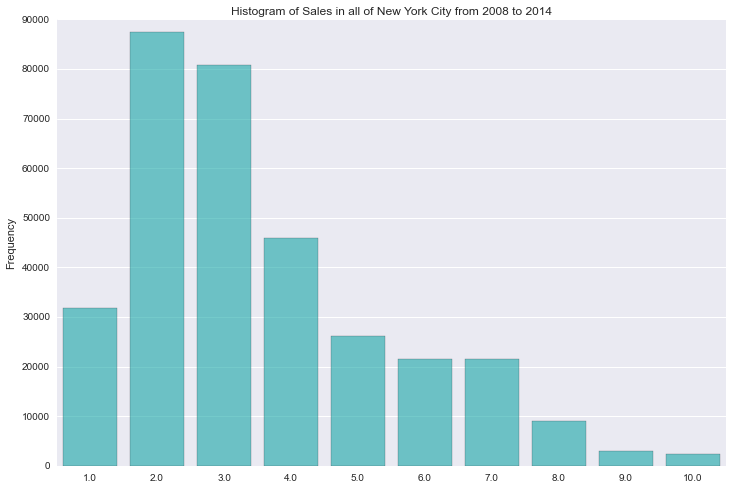

In [229]:
fig, ax = plt.subplots(figsize=(12,8))
df = pd.DataFrame.from_dict(count, 'index')
sns.barplot(x=df.index,y=df[0],color='c',alpha=0.6)
plt.title('Histogram of Sales in all of New York City from 2008 to 2014')
plt.ylabel('Frequency')
ax.xaxis.get_majorticklocs()
#ax.xaxis.set_ticks(x_ticks)
#plt.xticks([i for i in labels],[str(w) for w in x_ticks]) 

### Summaries by Zip Codes

In [230]:
final = final.merge(zipcodes,on='ZIP_CODE',how='inner')
final = gpd.GeoDataFrame(final) # For plotting

In [231]:
# Get statistics
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).mean()
print final['SALE_PRICE'].groupby(final['TAX_CLASS_AT_TIME_OF_SALE']).std()

TAX_CLASS_AT_TIME_OF_SALE
1     585924
2    1262491
Name: SALE_PRICE, dtype: int64
TAX_CLASS_AT_TIME_OF_SALE
1     881948.168329
2    9489107.894706
Name: SALE_PRICE, dtype: float64


In [289]:
# Get summaries
tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                     'PRICE_BINS'],axis=0).size()}).reset_index()
total_breakdown = pd.DataFrame({'COUNT':final.groupby(['TAX_CLASS_AT_TIME_OF_SALE',
                                                       'PRICE_BINS','ZIP_CODE'],axis=0).size()}).reset_index()
total1 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==1]['COUNT'].sum()
total2 = tax_breakdown[tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2]['COUNT'].sum()
tax_breakdown['SHARE'] = np.where(tax_breakdown['TAX_CLASS_AT_TIME_OF_SALE']==2,
                                  tax_breakdown['COUNT']/total2, tax_breakdown['COUNT']/total1)
del total1
del total2

zip_tax_breakdown = pd.DataFrame({'COUNT':final.groupby(['ZIP_CODE','TAX_CLASS_AT_TIME_OF_SALE'],axis=0).size()}).reset_index()
total_per_zip = pd.DataFrame({'TOTAL_COUNT':final.groupby(['ZIP_CODE'],axis=0).size()}).reset_index()

# Normalize each count by total sales count and maybe by population
zip_tax_breakdown = zip_tax_breakdown.merge(total_per_zip,on='ZIP_CODE',how='inner')
del total_per_zip

In [291]:
tax_breakdown # For each tax class and price category the number of sales

,TAX_CLASS_AT_TIME_OF_SALE,PRICE_BINS,COUNT,SHARE
0,1,1,9443,0.063415
1,1,2,47273,0.317467
2,1,3,49363,0.331502
3,1,4,23751,0.159502
4,1,5,10584,0.071078
5,1,6,4514,0.030314
6,1,7,2590,0.017393
7,1,8,877,0.005890
8,1,9,290,0.001948
9,1,10,222,0.001491


In [293]:
total_breakdown.head() # For each zip code, for each tax class, for each price category...

,TAX_CLASS_AT_TIME_OF_SALE,PRICE_BINS,ZIP_CODE,COUNT
0,1,1,10001,1
1,1,1,10025,1
2,1,1,10026,1
3,1,1,10027,1
4,1,1,10030,1


In [295]:
zip_tax_breakdown.head() # Per Zip Code and Tax Class

,ZIP_CODE,TAX_CLASS_AT_TIME_OF_SALE,COUNT,TOTAL_COUNT
0,10001,1,8,1030
1,10001,2,1022,1030
2,10002,1,17,1681
3,10002,2,1664,1681
4,10003,1,48,4371


### Get Assessment data from DOF in order to compute effective tax rate (ETR)

In [243]:
assessment = pd.read_csv(zip_.open(filename_assessment))
del assessment['Unnamed: 0'] # Delete unnecessary columns

#### Choose whether current or final and whether transitional or actual

In [244]:
assessment['TAXABLE'] = assessment['CURAVT_A'] - assessment['CUREXT_A']

In [245]:
assessment = assessment[['BBLE','CURAVT_A','CUREXT_A','CUR_FV_T','TXCL','TAXABLE']]
assessment.rename(columns={'BBLE':'BBL'},inplace=True)

In [248]:
# Make sure BBL is same type for merging
assessment.BBL = assessment.BBL.astype(str)
final.BBL = final.BBL.astype(str)

#### Because data is longitudinal, merge on BBL and YEAR?

In [249]:
finale = final.merge(assessment,on='BBL',how='inner')

In [250]:
finale.info() # Approximately 300k observations remain

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 286856 entries, 0 to 286855
Data columns (total 18 columns):
ZIP_CODE                     286856 non-null int64
SALE_DATE                    286856 non-null datetime64[ns]
SALE_YEAR                    286856 non-null int64
PRICE_BINS                   286853 non-null float64
TAX_CLASS_AT_PRESENT         259966 non-null float64
APARTMENT_NUMBER             20841 non-null float64
RESIDENTIAL_UNITS            286856 non-null int64
TAX_CLASS_AT_TIME_OF_SALE    286856 non-null int64
SALE_PRICE                   286856 non-null int64
SALE_PRICE_UNIT              286856 non-null int64
BBL                          286856 non-null object
TAX_RATE                     286856 non-null float64
geometry                     286856 non-null object
CURAVT_A                     286856 non-null float64
CUREXT_A                     286856 non-null float64
CUR_FV_T                     286856 non-null float64
TXCL                         286856 non-n

#### Should we use info related to tax class at present or at time of sale? Market value from sale amount or from assessed value?

In [251]:
finale['TAX_PAID'] = finale.TAXABLE * finale.TAX_RATE
finale['EST_TAX_RATE'] = finale['TAX_PAID']/finale['CUR_FV_T']

#### Need total units and residential units

In [ ]:
# Calculating the number of units
finale['TAX_UNIT'] = np.where(finale['TOTAL_UNITS']==0,1,finale['TOTAL_UNITS'])
finale['SALE_UNIT'] = np.where(finale['RES_UNITS']==0,1,finale['RES_UNITS'])

# Estimate tax rate per unit
finale['TAX_RATE_PER_UNIT'] = np.round((finale.TAX_PAID/finale['TAX_UNIT'])/
                                       (finale.SALE_PRICE/finale['SALE_UNIT']),2)*100

